In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_data = datasets.ImageFolder("/data/raf/train", transform=transform)
val_data = datasets.ImageFolder("/data/raf/val", transform=transform)
test_data = datasets.ImageFolder("/data/raf/test", transform=transform)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class_names = train_data.classes
print("✅ Classes:", class_names)


✅ Classes: ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'suprise']


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True)

# Freeze backbone
for param in vgg16.features.parameters():
    param.requires_grad = True

# Replace classifier head
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(train_data.classes))
)

vgg16 = vgg16.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 230MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier.parameters(), lr=1e-3)


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 | Avg Loss: 0.6001 | Train Acc: 0.7838 | Val Acc: 0.7763
Epoch 2/10 | Avg Loss: 0.4530 | Train Acc: 0.8369 | Val Acc: 0.8030
Epoch 3/10 | Avg Loss: 0.3601 | Train Acc: 0.8692 | Val Acc: 0.8140
Epoch 4/10 | Avg Loss: 0.2845 | Train Acc: 0.8962 | Val Acc: 0.8240
Epoch 5/10 | Avg Loss: 0.2477 | Train Acc: 0.9112 | Val Acc: 0.8255
Epoch 6/10 | Avg Loss: 0.2122 | Train Acc: 0.9238 | Val Acc: 0.8302
Epoch 7/10 | Avg Loss: 0.1918 | Train Acc: 0.9312 | Val Acc: 0.8192
Epoch 8/10 | Avg Loss: 0.1655 | Train Acc: 0.9413 | Val Acc: 0.8263
Epoch 9/10 | Avg Loss: 0.1576 | Train Acc: 0.9446 | Val Acc: 0.8305
Epoch 10/10 | Avg Loss: 0.1535 | Train Acc: 0.9467 | Val Acc: 0.8302


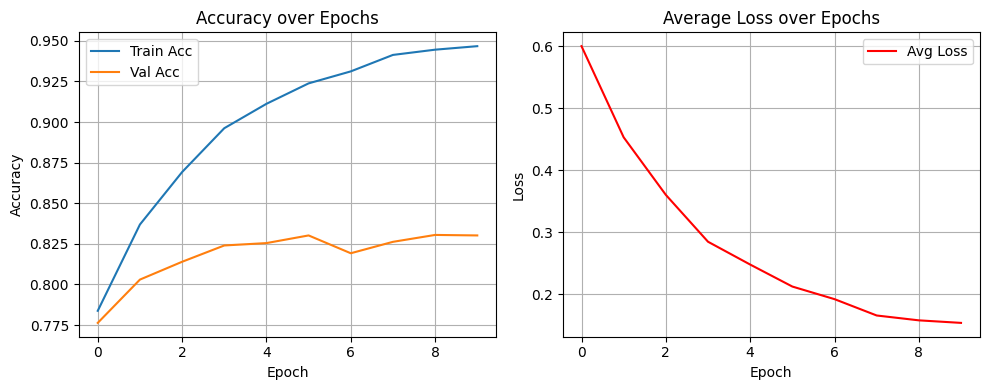

In [ ]:
vgg16 = train_model(vgg16, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.8284

              precision    recall  f1-score   support

       angry       0.76      0.82      0.79       898
    contempt       0.97      0.97      0.97       898
     disgust       0.93      0.98      0.96       898
        fear       0.90      0.88      0.89       898
       happy       0.86      0.75      0.80       898
     neutral       0.71      0.67      0.69       898
         sad       0.69      0.72      0.70       898
     suprise       0.82      0.84      0.83       898

    accuracy                           0.83      7184
   macro avg       0.83      0.83      0.83      7184
weighted avg       0.83      0.83      0.83      7184



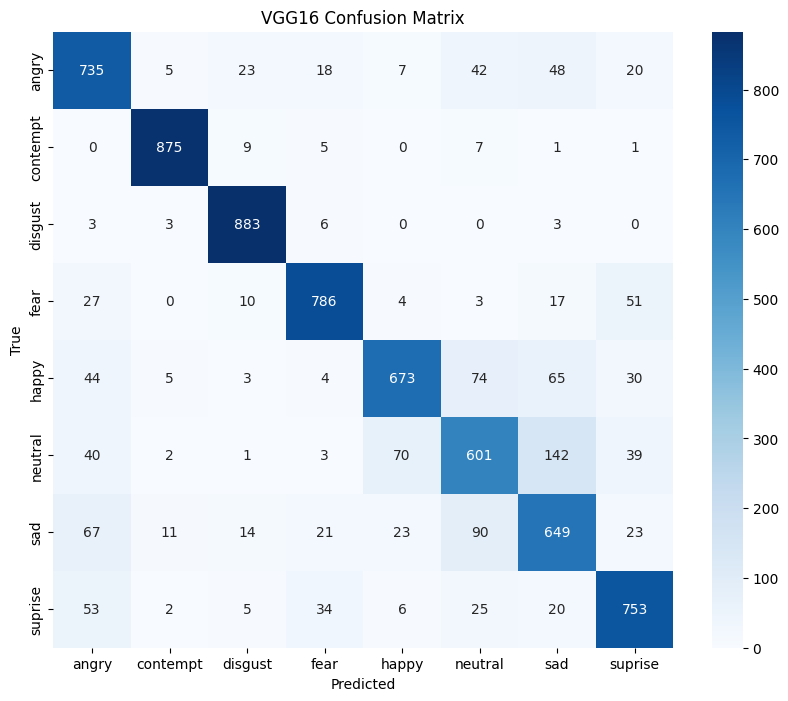

In [ ]:
vgg16.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Report
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap='Blues')
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Entire Model Train

Epoch 1/10 | Avg Loss: 0.9889 | Train Acc: 0.6478 | Val Acc: 0.7587
Epoch 2/10 | Avg Loss: 0.5903 | Train Acc: 0.7849 | Val Acc: 0.7895
Epoch 3/10 | Avg Loss: 0.4474 | Train Acc: 0.8395 | Val Acc: 0.8091
Epoch 4/10 | Avg Loss: 0.3558 | Train Acc: 0.8726 | Val Acc: 0.8167
Epoch 5/10 | Avg Loss: 0.2866 | Train Acc: 0.8957 | Val Acc: 0.8191
Epoch 6/10 | Avg Loss: 0.2419 | Train Acc: 0.9125 | Val Acc: 0.8253
Epoch 7/10 | Avg Loss: 0.2142 | Train Acc: 0.9236 | Val Acc: 0.8263
Epoch 8/10 | Avg Loss: 0.1899 | Train Acc: 0.9327 | Val Acc: 0.8225
Epoch 9/10 | Avg Loss: 0.1741 | Train Acc: 0.9377 | Val Acc: 0.8199
Epoch 10/10 | Avg Loss: 0.1529 | Train Acc: 0.9470 | Val Acc: 0.8237


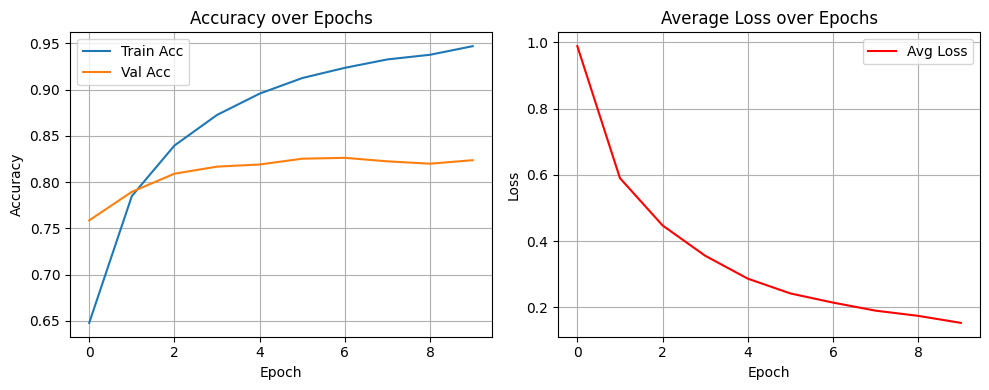

In [ ]:
vgg16 = train_model(vgg16, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.8244

              precision    recall  f1-score   support

       angry       0.81      0.76      0.78       898
    contempt       0.94      0.98      0.96       898
     disgust       0.92      0.98      0.95       898
        fear       0.91      0.84      0.88       898
       happy       0.82      0.78      0.80       898
     neutral       0.67      0.74      0.70       898
         sad       0.72      0.70      0.71       898
     suprise       0.82      0.82      0.82       898

    accuracy                           0.82      7184
   macro avg       0.83      0.82      0.82      7184
weighted avg       0.83      0.82      0.82      7184



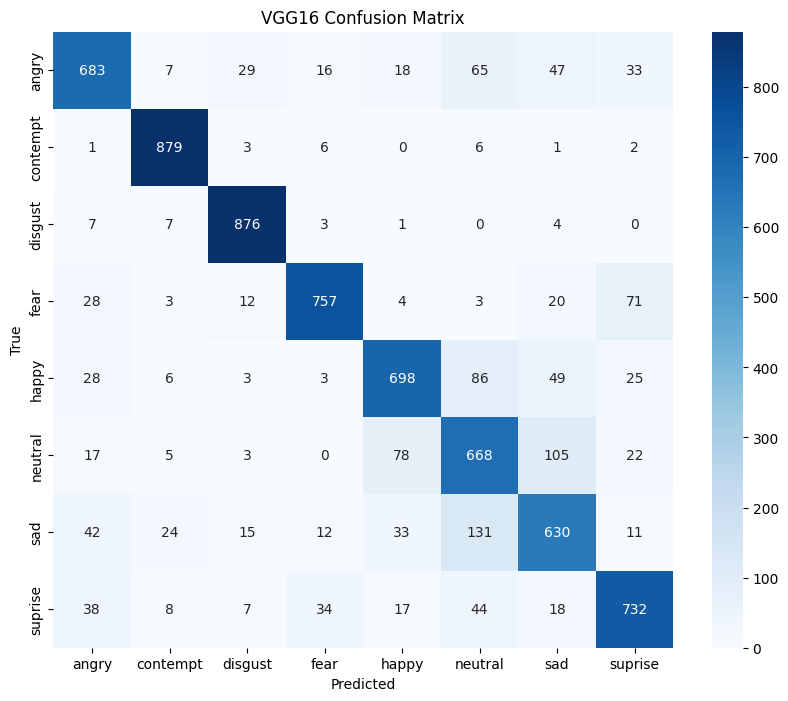

In [ ]:
vgg16.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# Report
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap='Blues')
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
